# FloPy 

### Working stack demo

A short demonstration of core `flopy` functionality

In [1]:
from IPython.display import clear_output, display

import os
import sys
from tempfile import TemporaryDirectory

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd

# run installed version of flopy or add local path
try:
    import flopy
except:
    fpth = os.path.abspath(os.path.join("..", ".."))
    sys.path.append(fpth)
    import flopy

print(sys.version)
print("numpy version: {}".format(np.__version__))
print("matplotlib version: {}".format(mpl.__version__))
print("pandas version: {}".format(pd.__version__))
print("flopy version: {}".format(flopy.__version__))

3.9.7 (default, Sep 16 2021, 08:50:36) 
[Clang 10.0.0 ]
numpy version: 1.23.2
matplotlib version: 3.5.3
pandas version: 1.4.1
flopy version: 3.3.6


### Model Inputs

In [2]:
# first lets load an existing model
model_ws = os.path.join("..", "data", "freyberg_multilayer_transient")
ml = flopy.modflow.Modflow.load(
    "freyberg.nam",
    model_ws=model_ws,
    verbose=False,
    check=False,
    exe_name="mfnwt",
)

In [3]:
ml.modelgrid

xll:622241.1904510253; yll:3343617.741737109; rotation:15.0; proj4_str:+proj=utm +zone=14 +ellps=WGS84 +datum=WGS84 +units=m +no_defs; units:meters; lenuni:2

Let's looks at some plots

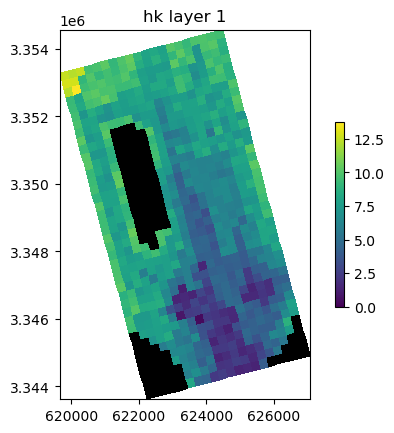

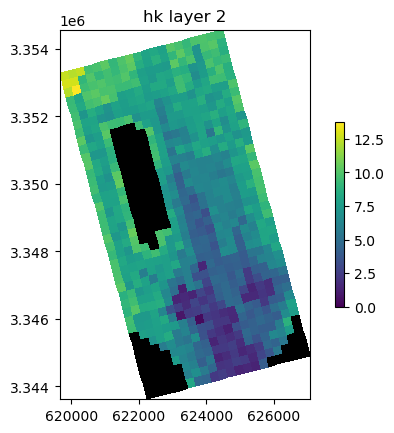

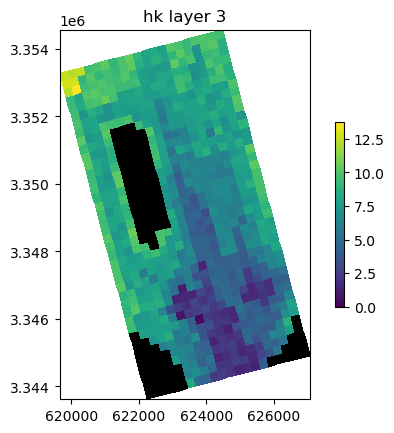

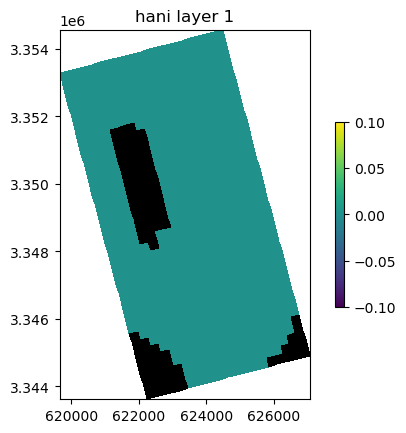

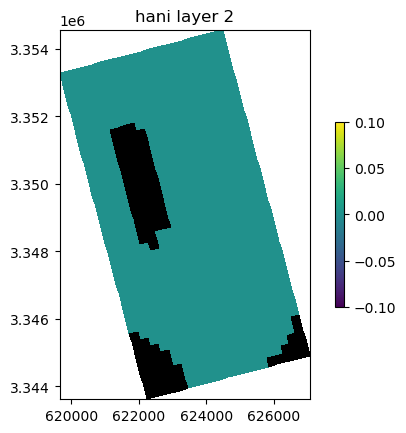

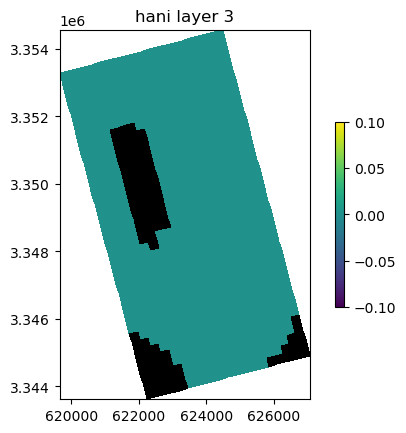

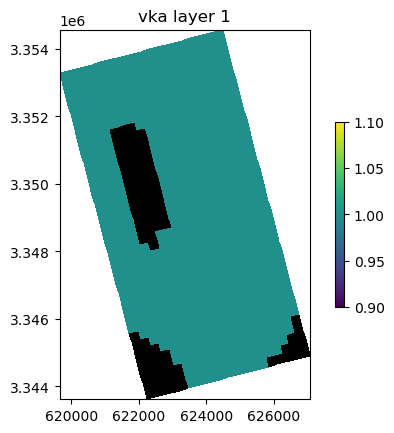

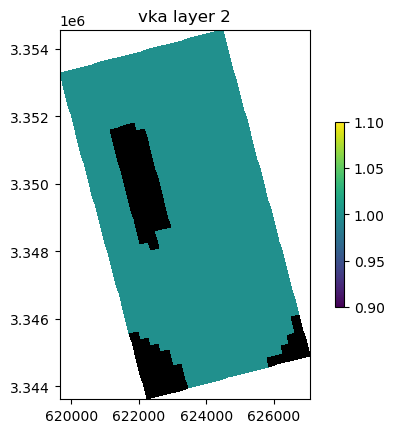

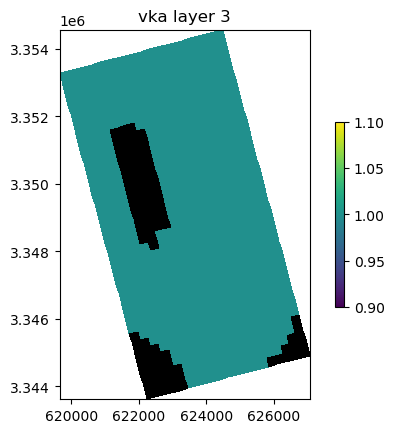

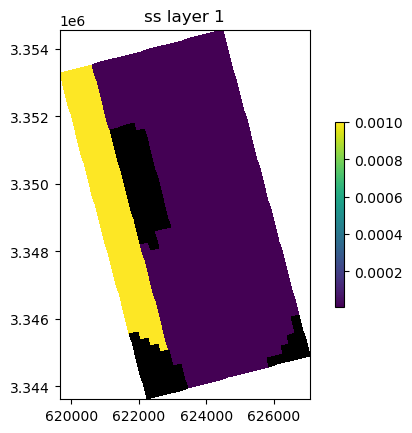

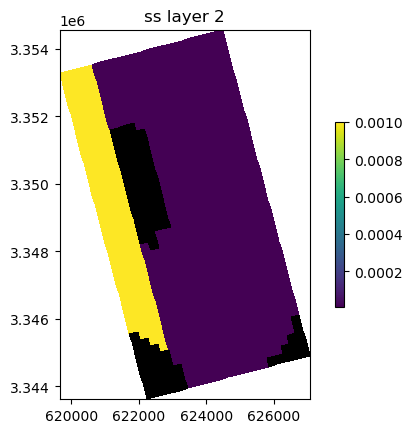

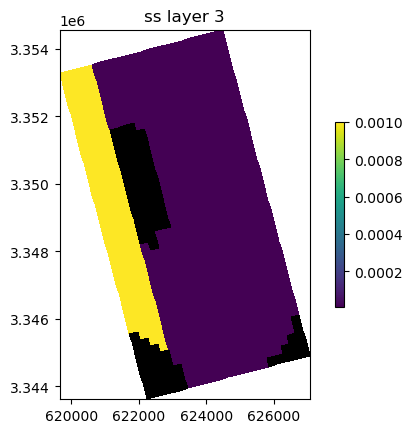

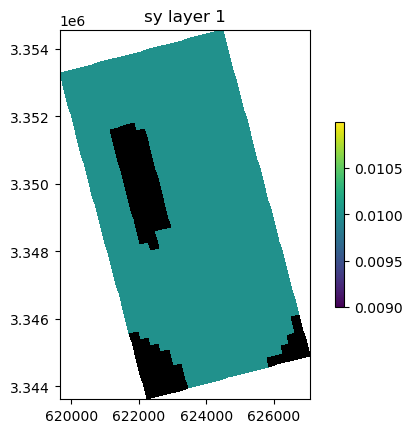

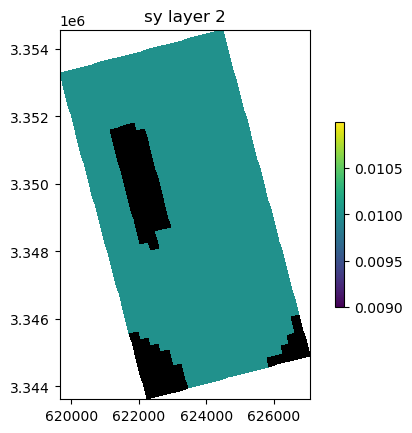

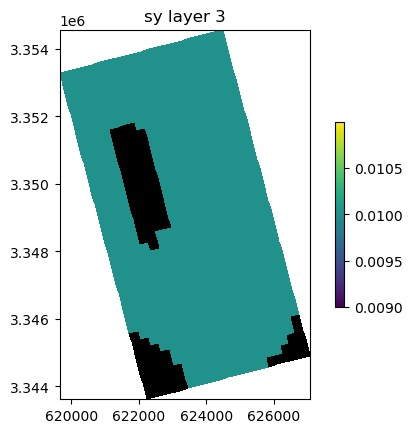

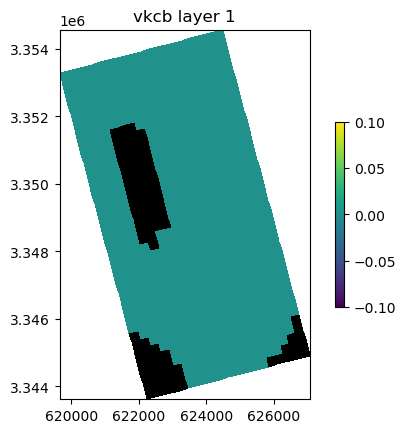

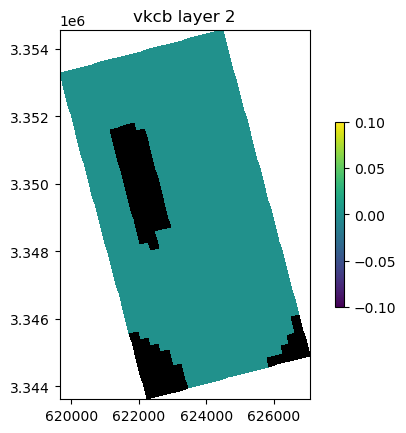

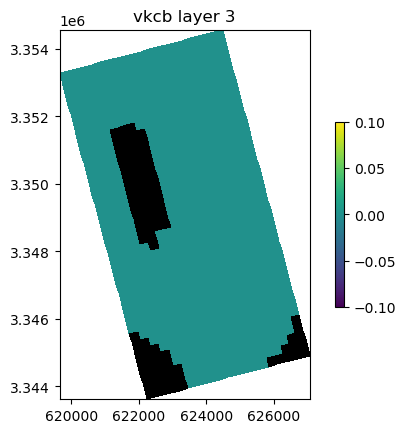

In [4]:
ml.upw.plot();

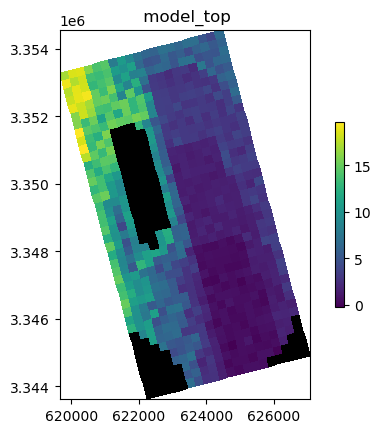

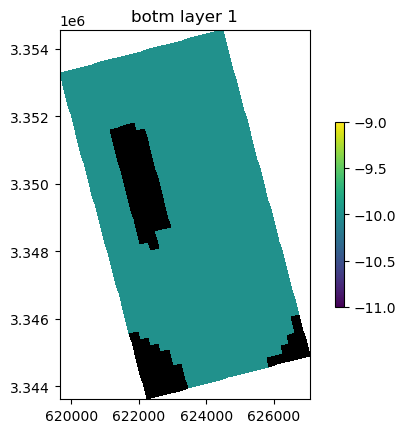

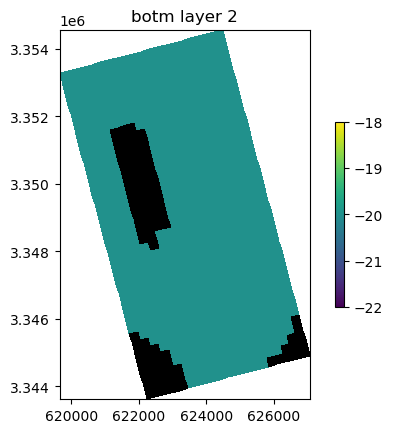

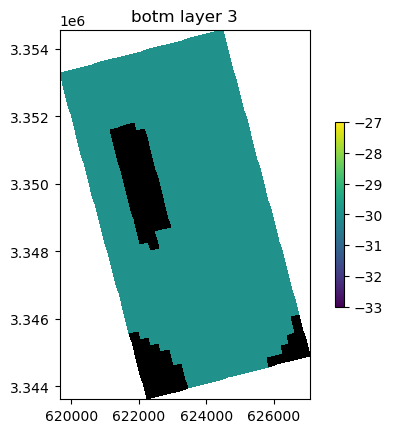

In [5]:
ml.dis.plot();

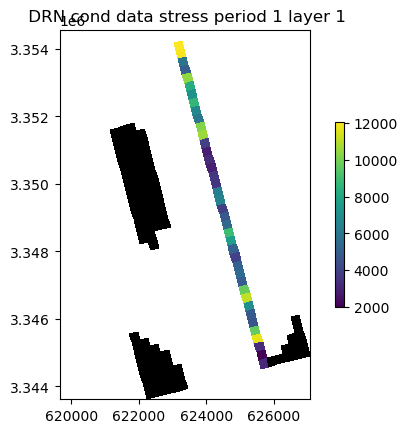

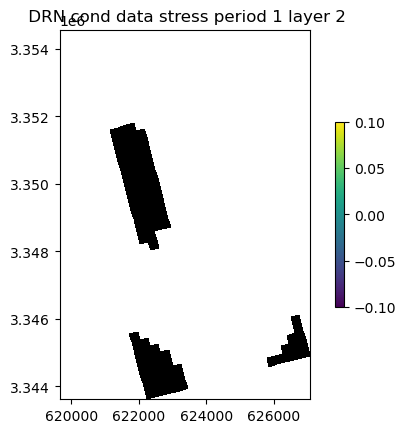

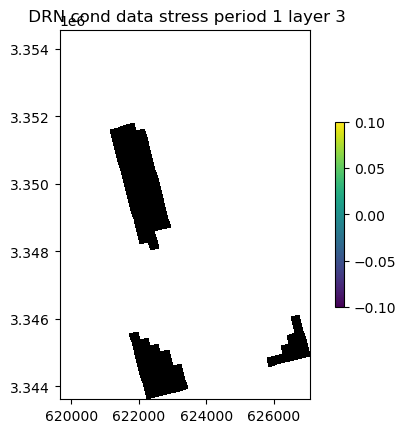

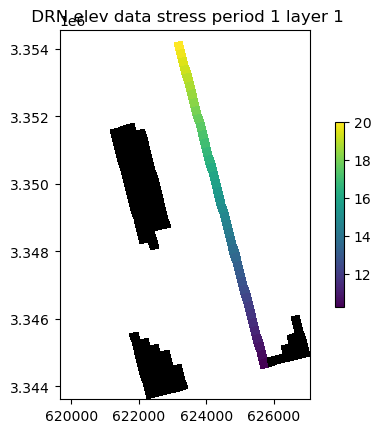

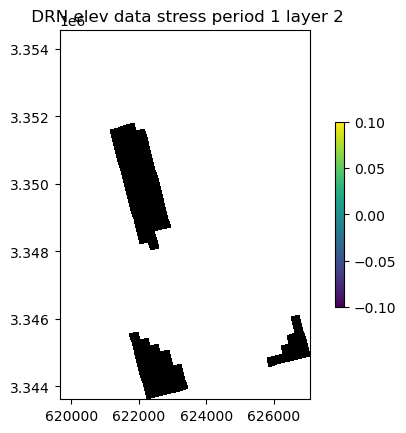

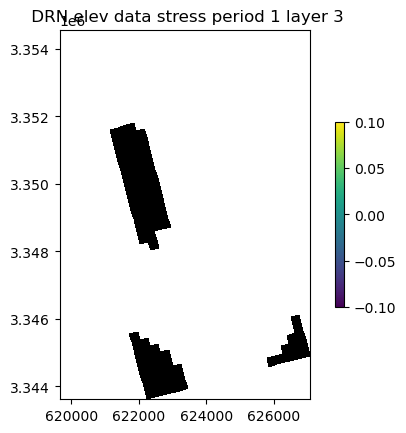

In [6]:
ml.drn.plot(key="cond")
ml.drn.plot(key="elev");

Let's write a shapefile of the DIS package

In [7]:
temp_dir = TemporaryDirectory()
workspace = temp_dir.name

ml.dis.export(os.path.join(workspace, "freyberg_dis.shp"))

wrote /var/folders/j_/t2vm99cn5y331ngvvv37nzw05b8bfj/T/tmp_07wnq4g/freyberg_dis.shp


Let's also write a netCDF file with all model inputs

In [8]:
ml.export(os.path.join(workspace, "freyberg.nc"))

initialize_geometry::proj4_str = +proj=utm +zone=14 +ellps=WGS84 +datum=WGS84 +units=m +no_defs
initialize_geometry::self.grid_crs = +proj=utm +zone=14 +ellps=WGS84 +datum=WGS84 +units=m +no_defs +type=crs
initialize_geometry::nc_crs = epsg:4326
transforming coordinates using = proj=pipeline step inv proj=utm zone=14 ellps=WGS84 step proj=unitconvert xy_in=rad xy_out=deg


### Change model directory, modify inputs and write new input files

In [9]:
ml.external_path = os.path.join(workspace, "ref")
ml.model_ws = workspace

### Run the model

In [10]:
ml.write_input()

ml.run_model()

Util2d:delr: resetting 'how' to external
Util2d:delc: resetting 'how' to external
Util2d:model_top: resetting 'how' to external
Util2d:botm_layer_0: resetting 'how' to external
Util2d:botm_layer_1: resetting 'how' to external
Util2d:botm_layer_2: resetting 'how' to external
Util2d:ibound_layer_0: resetting 'how' to external
Util2d:ibound_layer_1: resetting 'how' to external
Util2d:ibound_layer_2: resetting 'how' to external
Util2d:strt_layer_0: resetting 'how' to external
Util2d:strt_layer_1: resetting 'how' to external
Util2d:strt_layer_2: resetting 'how' to external
Util2d:rech_1: resetting 'how' to external
Util2d:rech_2: resetting 'how' to external
Util2d:rech_3: resetting 'how' to external
Util2d:rech_4: resetting 'how' to external
Util2d:rech_5: resetting 'how' to external
Util2d:rech_6: resetting 'how' to external
Util2d:rech_7: resetting 'how' to external
Util2d:rech_8: resetting 'how' to external
Util2d:rech_9: resetting 'how' to external
Util2d:rech_10: resetting 'how' to ext

(True, [])

### Output inspection

First, let's look at the list file

In [11]:
mfl = flopy.utils.MfListBudget(os.path.join(model_ws, "freyberg.list"))
df_flux, df_vol = mfl.get_dataframes(start_datetime="10-21-2015")
df_flux

,STORAGE_IN,CONSTANT_HEAD_IN,WELLS_IN,DRAINS_IN,RECHARGE_IN,TOTAL_IN,STORAGE_OUT,CONSTANT_HEAD_OUT,WELLS_OUT,DRAINS_OUT,RECHARGE_OUT,TOTAL_OUT,IN-OUT,PERCENT_DISCREPANCY
2015-10-22,0.000000,0.000000,0.0,0.0,6276.861816,6276.861816,0.000000,2446.318848,0.000000,3830.650146,0.0,6276.968750,-0.106900,-0.0
2015-10-23,635.447998,0.000000,0.0,0.0,6428.198730,7063.646484,31.594000,2430.337891,1302.403198,3299.415039,0.0,7063.750000,-0.103500,-0.0
2015-10-24,1361.814941,0.000000,0.0,0.0,5397.295898,6759.110840,9.152200,2369.628174,1618.676392,2761.639648,0.0,6759.096191,0.014648,0.0
2015-10-25,677.577209,0.000000,0.0,0.0,5931.377441,6608.954590,180.233307,2353.585449,1498.694702,2576.461670,0.0,6608.975586,-0.020996,-0.0
2015-10-26,697.818298,0.000000,0.0,0.0,8378.572266,9076.390625,1051.897461,2417.248291,3119.501953,2487.737305,0.0,9076.384766,0.005859,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-10-18,1298.433350,23.293699,0.0,0.0,4240.286133,5562.013184,1606.280396,1909.538574,1930.483154,115.724899,0.0,5562.026855,-0.013672,-0.0
2018-10-19,920.468689,25.997499,0.0,0.0,4082.749512,5029.215820,1659.194702,1892.605835,1279.166382,198.258896,0.0,5029.225586,-0.009766,-0.0
2018-10-20,496.671387,20.047001,0.0,0.0,5053.779297,5570.497559,2428.291016,1933.045898,794.582886,414.594513,0.0,5570.514648,-0.017090,-0.0
2018-10-21,230.320999,9.045700,0.0,0.0,6168.920410,6408.287109,2335.759521,2006.124268,1373.782593,692.638123,0.0,6408.304688,-0.017578,-0.0


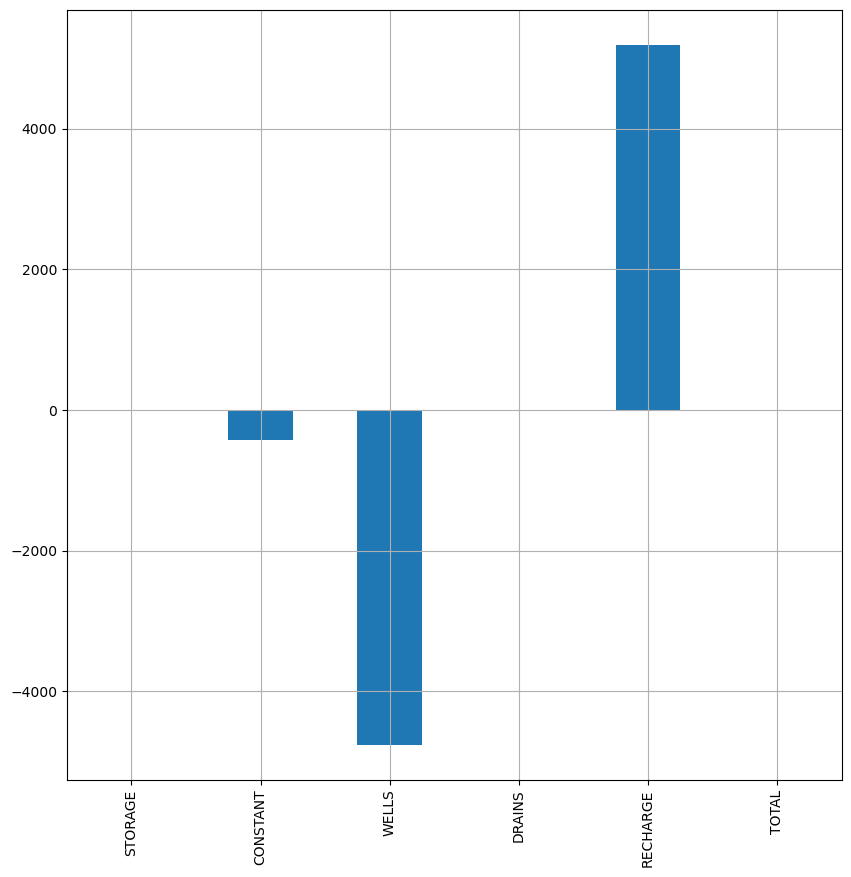

In [12]:
groups = df_flux.groupby(lambda x: x.split("_")[-1], axis=1).groups
df_flux_in = df_flux.loc[:, groups["IN"]]
df_flux_in.columns = df_flux_in.columns.map(lambda x: x.split("_")[0])

df_flux_out = df_flux.loc[:, groups["OUT"]]
df_flux_out.columns = df_flux_out.columns.map(lambda x: x.split("_")[0])


df_flux_delta = df_flux_in - df_flux_out
df_flux_delta.iloc[-1, :].plot(kind="bar", figsize=(10, 10), grid=True);

### Let's look at the simulated head

In [13]:
# if you pass the model instance, then the plots will be offset and rotated
h = flopy.utils.HeadFile(os.path.join(model_ws, "freyberg.hds"), model=ml)
h.times

[1.0,
 2.0,
 3.0,
 4.0,
 5.0,
 6.0,
 7.0,
 8.0,
 9.0,
 10.0,
 11.0,
 12.0,
 13.0,
 14.0,
 15.0,
 16.0,
 17.0,
 18.0,
 19.0,
 20.0,
 21.0,
 22.0,
 23.0,
 24.0,
 25.0,
 26.0,
 27.0,
 28.0,
 29.0,
 30.0,
 31.0,
 32.0,
 33.0,
 34.0,
 35.0,
 36.0,
 37.0,
 38.0,
 39.0,
 40.0,
 41.0,
 42.0,
 43.0,
 44.0,
 45.0,
 46.0,
 47.0,
 48.0,
 49.0,
 50.0,
 51.0,
 52.0,
 53.0,
 54.0,
 55.0,
 56.0,
 57.0,
 58.0,
 59.0,
 60.0,
 61.0,
 62.0,
 63.0,
 64.0,
 65.0,
 66.0,
 67.0,
 68.0,
 69.0,
 70.0,
 71.0,
 72.0,
 73.0,
 74.0,
 75.0,
 76.0,
 77.0,
 78.0,
 79.0,
 80.0,
 81.0,
 82.0,
 83.0,
 84.0,
 85.0,
 86.0,
 87.0,
 88.0,
 89.0,
 90.0,
 91.0,
 92.0,
 93.0,
 94.0,
 95.0,
 96.0,
 97.0,
 98.0,
 99.0,
 100.0,
 101.0,
 102.0,
 103.0,
 104.0,
 105.0,
 106.0,
 107.0,
 108.0,
 109.0,
 110.0,
 111.0,
 112.0,
 113.0,
 114.0,
 115.0,
 116.0,
 117.0,
 118.0,
 119.0,
 120.0,
 121.0,
 122.0,
 123.0,
 124.0,
 125.0,
 126.0,
 127.0,
 128.0,
 129.0,
 130.0,
 131.0,
 132.0,
 133.0,
 134.0,
 135.0,
 136.0,
 137.0,
 138.0,
 139

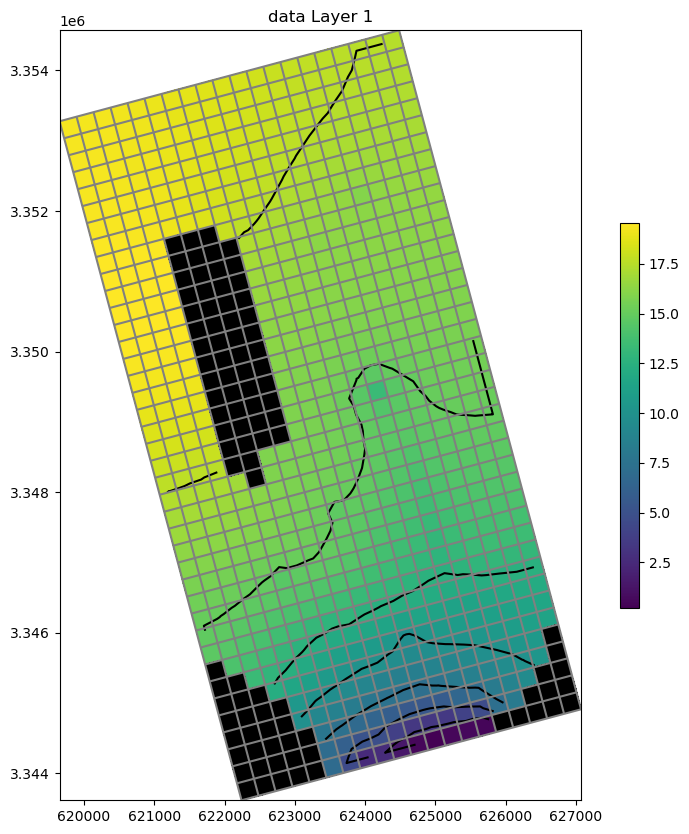

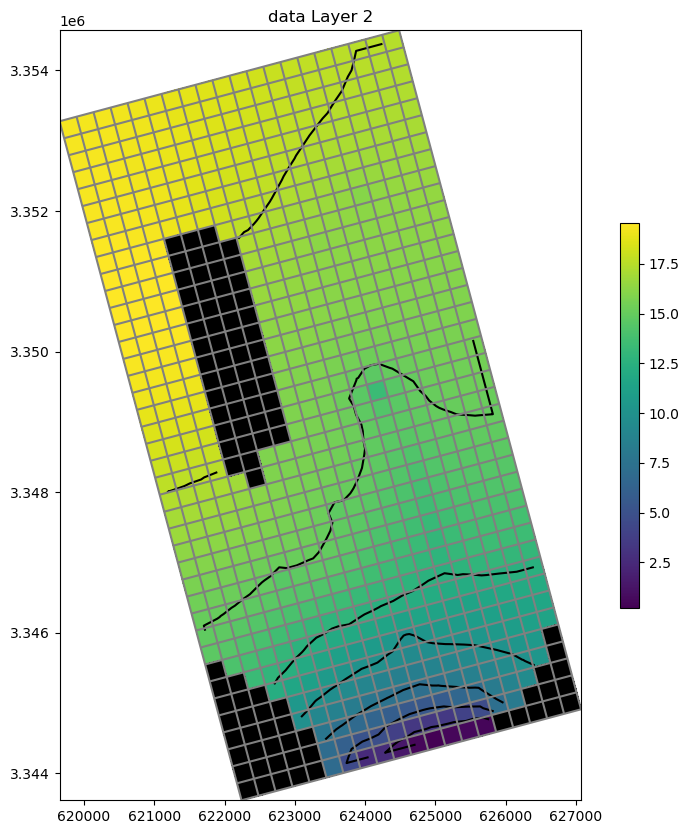

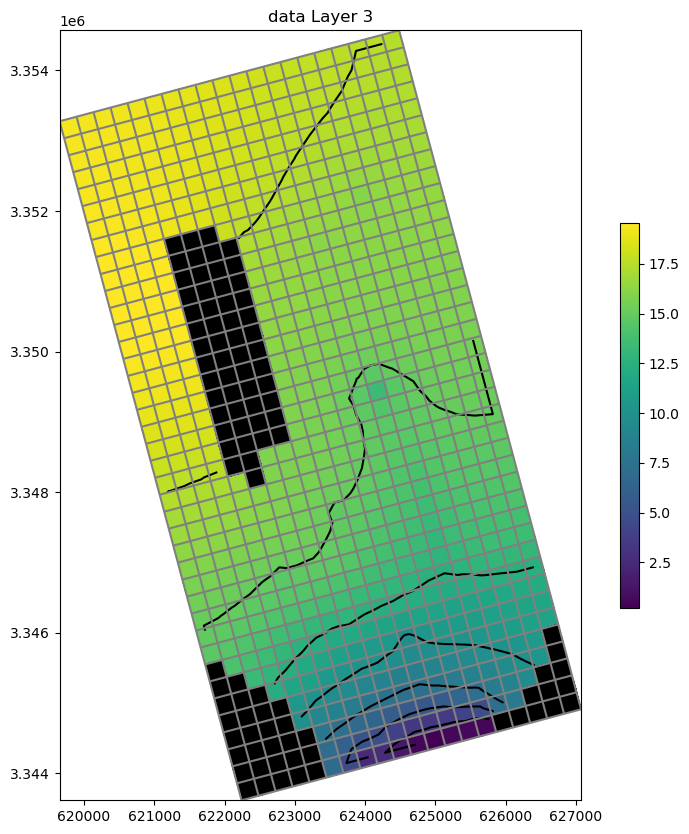

In [14]:
h.plot(totim=900, contour=True, grid=True, colorbar=True, figsize=(10, 10));

### Write the heads to a shapefile

In [15]:
# let's write these heads to shapefile
h.to_shapefile(os.path.join(ml.model_ws, "freyburg_head.shp"))

wrote /var/folders/j_/t2vm99cn5y331ngvvv37nzw05b8bfj/T/tmp_07wnq4g/freyburg_head.shp


### Let's make a movie of the model output

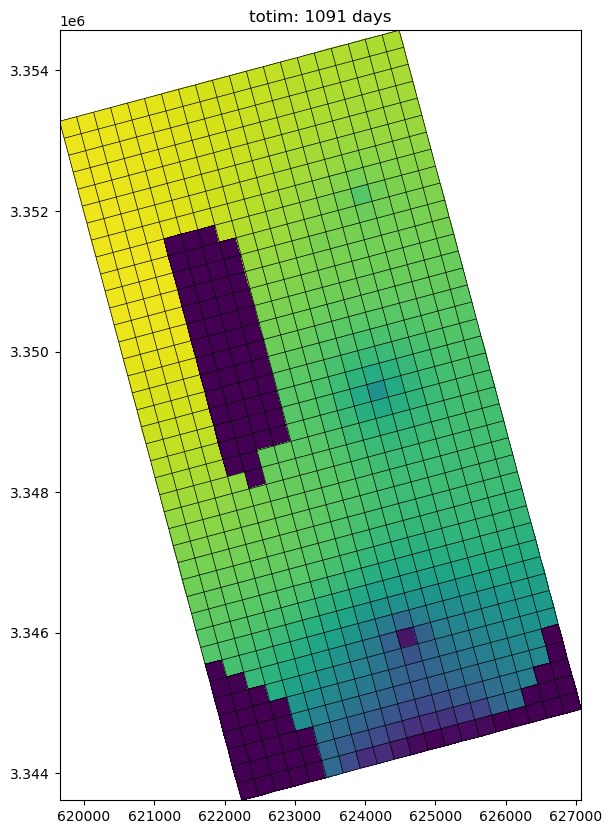

In [16]:
f = plt.figure(figsize=(10, 10))
ax = plt.subplot(1, 1, 1, aspect="equal")
for t in h.times[0:-1:10]:
    ax.cla()
    
    ax.set_title(f"totim: {t:4.0f} days")
    mm = flopy.plot.PlotMapView(model=ml, ax=ax)
    mm.plot_array(h.get_data(totim=t), vmin=0, vmax=20)
    mm.plot_grid(lw=0.5, color="black")
    
    display(f)    
    clear_output(wait = True)
    plt.pause(0.1); 
    

In [17]:
try:
    # ignore PermissionError on Windows
    temp_dir.cleanup()
except:
    pass